In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
from tab_benchmark.datasets import datasets_characteristics_path
from itertools import product
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt

# Save Results

## Load mlflow runs

In [2]:
db_port = 5003
db_name = 'tab_benchmark'
w = 'clust9'
# url = f'postgresql://{w}.ceremade.dauphine.lan:{db_port}/{db_name}'
url = f'postgresql://belucci@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
# results_dir = Path('~/tab_benchmark/results')
# os.makedirs(results_dir, exist_ok=True)

In [3]:
experiment_names

['Default',
 'dnn_classification',
 'dnn_regression',
 'gbdt_classification',
 'gbdt_regression',
 'dnn_classification_others',
 'xgb_hpo_classification',
 'dnn_classification_transformer_max_1h']

In [37]:
experiment_names = [
    'dnn_classification', 'gbdt_classification', 'dnn_classification_others'
]

In [38]:
params_columns = [
    'model_nickname',
    'model_name',
    'seed_model',
    'dataset_name',
    'task_id',
    'task_name',
    'task_fold',
    'n_gpus',
]

In [39]:
latest_metrics_columns = [
    'final_test_logloss',
    'final_test_auc',
    'final_test_auc_0',
    'final_test_auc_1',
    'elapsed_time',
]

In [40]:
tags_columns = [
    'was_evaluated',
    'EXCEPTION',
]

In [41]:
params_columns_query = [f"'{p}'" for p in params_columns]
params_columns_query = ', '.join(params_columns_query)

In [42]:
experiment_names_query = [f"'{e}'" for e in experiment_names]
experiment_names_query = ', '.join(experiment_names_query)

In [43]:
query = f"""
SELECT
	runs.run_uuid,
    runs.status,
    runs.start_time,
    runs.end_time,
	params."key",
	params.value
FROM
	runs
LEFT JOIN params ON
	params.run_uuid = runs.run_uuid
LEFT JOIN experiments ON
	experiments.experiment_id = runs.experiment_id
WHERE
	params."key" IN ({params_columns_query})
	AND experiments.name IN ({experiment_names_query})
"""
df_params = pd.read_sql(query, engine)
df_params = df_params.pivot(columns='key', index=['run_uuid', 'status', 'start_time', 'end_time'], values='value').reset_index()
df_params = df_params.set_index('run_uuid')

In [44]:
latest_metrics_columns_query = [f"'{m}'" for m in latest_metrics_columns]
latest_metrics_columns_query = ', '.join(latest_metrics_columns_query)

In [45]:
query = f"""
SELECT
	runs.run_uuid,
	latest_metrics."key",
	latest_metrics.value
FROM
	runs
LEFT JOIN latest_metrics ON
	latest_metrics.run_uuid = runs.run_uuid
LEFT JOIN experiments ON
	experiments.experiment_id = runs.experiment_id
WHERE
	latest_metrics."key" IN ({latest_metrics_columns_query})
	AND experiments.name IN ({experiment_names_query})
"""
df_latest_metrics = pd.read_sql(query, engine)
df_latest_metrics = df_latest_metrics.pivot(columns='key', index='run_uuid', values='value')

In [46]:
tags_columns_query = [f"'{tag}'" for tag in tags_columns]
tags_columns_query = ', '.join(tags_columns_query)

In [47]:
query = f"""
SELECT
	runs.run_uuid,
	tags."key",
	tags.value
FROM
	runs
LEFT JOIN tags ON
	tags.run_uuid = runs.run_uuid
LEFT JOIN experiments ON
	experiments.experiment_id = runs.experiment_id
WHERE
	tags."key" IN ({tags_columns_query})
	AND experiments.name IN ({experiment_names_query})
"""
df_tags = pd.read_sql(query, engine)
df_tags = df_tags.pivot(columns='key', index='run_uuid', values='value')

In [49]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)

In [50]:
df_runs_raw

key,status,start_time,end_time,dataset_name,model_name,model_nickname,n_gpus,seed_model,task_fold,task_id,task_name,elapsed_time,final_test_auc,final_test_auc_0,final_test_auc_1,final_test_logloss,EXCEPTION,was_evaluated
run_uuid,,,,,,,,,,,,,,,,,,
00041295adf6408b98d494e867298b73,FINISHED,1726250759876,1.726251e+12,house_16H,XGBClassifier,TabBenchmarkXGBClassifier,0,0,7,3686,binary_classification,4.0,NaN,0.047283,0.952717,0.250468,NaN,True
00083774fba44fb18ad8ad1ffd1b872b,FINISHED,1726261646899,1.726262e+12,sonar,MLP,TabBenchmarkMLP,0,0,6,39,binary_classification,152.0,NaN,0.181818,0.818182,0.580241,NaN,True
000a8cfefda64cf6a167df2a708afb51,FINISHED,1726579322368,1.726585e+12,pendigits,Transformer,TabBenchmarkTransformer,0,0,3,32,classification,6006.0,0.998939,NaN,NaN,0.047548,NaN,True
000fe9adec414671b4351d0a59068b5a,FINISHED,1726498691179,1.726502e+12,MiniBooNE,ResNet,TabBenchmarkResNet,0,0,3,168335,binary_classification,3234.0,NaN,0.016003,0.983997,0.144317,NaN,True
000fed3e509e4798860d517d73053b89,FINISHED,1726390097040,1.726394e+12,JapaneseVowels,MLP,TabBenchmarkMLP,0,0,8,3510,classification,3463.0,0.999885,NaN,NaN,0.033935,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff398eb93e44723965b7ad6d3c402b4,FINISHED,1726480473007,1.726480e+12,haberman,XGBClassifier,TabBenchmarkXGBClassifier,0,0,3,42,binary_classification,0.0,NaN,0.478261,0.521739,0.571754,NaN,True
fffd37c94d70462d95975f12e6349dfa,FINISHED,1726886027263,1.726886e+12,wdbc,TabNet,TabBenchmarkTabNet,0,0,2,9946,binary_classification,13.0,NaN,0.035714,0.964286,0.246439,NaN,True
fffd70ef80eb428099e2310c82d05054,FINISHED,1726574894958,1.726575e+12,visualizing_environmental,CatBoostClassifier,TabBenchmarkCatBoostClassifier,0,0,3,3602,binary_classification,1.0,NaN,0.200000,0.800000,0.460515,NaN,True


## Load specs file with all datasets being used

In [51]:
datasets_characteristics = pd.read_csv(datasets_characteristics_path)
datasets_classification = datasets_characteristics.loc[datasets_characteristics.task_name.isin(('classification', 'binary_classification'))]

## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [52]:
non_duplicate_columns = [
    'model_name',
    'seed_model',
    'task_id',
    'task_fold',    
]

In [53]:
df_runs = df_runs_raw.dropna(axis=0, how='all', subset=['final_test_logloss']).copy()
df_runs = df_runs.loc[(~df_runs.duplicated(non_duplicate_columns))]

In [54]:
# # some combinations of model-dataset will never run (memory needed is too high > 2 TiB)
# model_to_input = ['SkRandomForestModel', 'SkExtraTreeModel', 'SkGradientBoostingModel', 'SkExtraTreesModel', 'SkDecisionTreeModel', 'SkRidgeClassifierCVModel']
# dataset_name_to_input = ['albert']
# folds_to_input = [str(i) for i in range(5)]
# seed_dataset_to_input = ['0']
# seed_model_to_input = ['0']
# for model_name in model_to_input:
#     for dataset_name in dataset_name_to_input:
#         for fold in folds_to_input:
#             for seed_dataset in seed_dataset_to_input:
#                 for seed_model in seed_model_to_input:
#                     data_to_cat = {
#                         'model_name': model_name,
#                         'dataset_name': dataset_name,
#                         'fold': fold,
#                         'seed_model': seed_model,
#                         'seed_dataset': seed_dataset,
#                         'test_auc': 0,
#                         'test_logloss': 1e5,
#                         'duration': 1e5*3600
#                     }
#                     df_to_cat = pd.DataFrame(data_to_cat, index=[0])
#                     df_runs = pd.concat([df_runs, df_to_cat], axis=0)

# Missing

In [55]:
def get_missing_runs(df, columns_names, should_contain_values):
    df = df.copy()
    indexes = product(*should_contain_values)
    df_should_contain = pd.DataFrame(index=indexes)
    contain = [df[column_name] for column_name in columns_names]
    df['indexes'] = list(zip(*contain))
    df_missing = df.join(df_should_contain, 'indexes', how='right')
    df_missing = df_missing.loc[df_missing[columns_names[0]].isna()]
    df_missing = pd.DataFrame(df_missing.indexes.to_list(), columns=columns_names)
    return df_missing

In [56]:
df_runs['model_name'].unique().tolist()

['XGBClassifier',
 'MLP',
 'Transformer',
 'ResNet',
 'LGBMClassifier',
 'TabTransformer',
 'CatBoostClassifier',
 'TabNet',
 'Saint',
 'Node']

In [57]:
non_duplicate_columns = [
    'model_name',
    'seed_model',
    'task_id',
    'task_fold',    
]

In [61]:
seed_model = ['0']
model_name = [
    'XGBClassifier',
    'CatBoostClassifier',
    'LGBMClassifier',
    # 'MLP',
    # 'ResNet',
    # 'Transformer',
    # 'TabNet',
    # 'TabTransformer'
]
fold = [str(i) for i in range(10)]
columns_names = non_duplicate_columns
dataset_tasks = [str(task) for task in datasets_classification.task_id.unique()]
should_contain_values = [model_name, seed_model, dataset_tasks, fold]
df_missing = get_missing_runs(df_runs, columns_names, should_contain_values)

In [63]:
df_missing

,model_name,seed_model,task_id,task_fold
0,CatBoostClassifier,0,167121,4
1,CatBoostClassifier,0,167121,5
2,CatBoostClassifier,0,167121,8
3,CatBoostClassifier,0,167121,9
4,CatBoostClassifier,0,146825,4
5,CatBoostClassifier,0,146825,5
6,CatBoostClassifier,0,146825,7
7,CatBoostClassifier,0,146825,8
8,CatBoostClassifier,0,146825,9
9,CatBoostClassifier,0,3952,4


In [25]:
print(*df_missing.task_id.unique())

167121 146825 3952 189355 168329 2076 9974 3573


# Get common combinations

In [24]:
def get_common_combinations(df, column, combination_columns):
    df = df.copy()
    column_values = df[column].unique()
    values_combinations = {}
    for column_value in column_values:
        df_column_value = df.loc[df[column] == column_value]
        combinations = df_column_value[combination_columns].itertuples(index=False, name=None)
        values_combinations[column_value] = set(combinations)
    common_combinations = set.intersection(*values_combinations.values())
    return common_combinations

In [25]:
def get_df_with_combinations(df, combination_columns, combinations):
    df = df.copy()
    df['combination'] = list(df[combination_columns].itertuples(index=False, name=None))
    df = df.loc[df['combination'].isin(combinations)]
    df = df.drop(columns='combination')
    return df

In [26]:
model_name = [
    'XGBClassifier',
    'CatBoostClassifier',
    'LGBMClassifier',
    'MLP',
    'ResNet',
    'Transformer',
    'TabNet'
    # 'TabTransformer'
]
df = df_runs.copy()
df = df.loc[df['model_name'].isin(model_name)]
column = 'model_name'
combination_columns = ['seed_model', 'task_id', 'task_fold']
common_combinations = get_common_combinations(df, column, combination_columns)

In [27]:
df_common = get_df_with_combinations(df, combination_columns, common_combinations)

In [28]:
df_common

key,status,start_time,end_time,EXCEPTION,SLURMD_NODENAME,dataset_name,model_name,model_nickname,seed_model,task_fold,task_id,task_name,was_evaluated,final_test_auc,final_test_auc_0,final_test_auc_1,final_test_logloss,duration
run_uuid,,,,,,,,,,,,,,,,,,
00041295adf6408b98d494e867298b73,FINISHED,1726250759876,1.726251e+12,NaN,clust10,house_16H,XGBClassifier,TabBenchmarkXGBClassifier,0,7,3686,binary_classification,True,NaN,0.047283,0.952717,0.250468,0.001176
00083774fba44fb18ad8ad1ffd1b872b,FINISHED,1726261646899,1.726262e+12,NaN,clust11,sonar,MLP,TabBenchmarkMLP,0,6,39,binary_classification,True,NaN,0.181818,0.818182,0.580241,0.042290
000a8cfefda64cf6a167df2a708afb51,FINISHED,1726579322368,1.726585e+12,NaN,clust3,pendigits,Transformer,TabBenchmarkTransformer,0,3,32,classification,True,0.998939,NaN,NaN,0.047548,1.668499
000fe9adec414671b4351d0a59068b5a,FINISHED,1726498691179,1.726502e+12,NaN,clust8,MiniBooNE,ResNet,TabBenchmarkResNet,0,3,168335,binary_classification,True,NaN,0.016003,0.983997,0.144317,0.898571
000fed3e509e4798860d517d73053b89,FINISHED,1726390097040,1.726394e+12,NaN,clust11,JapaneseVowels,MLP,TabBenchmarkMLP,0,8,3510,classification,True,0.999885,NaN,NaN,0.033935,0.962025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff398eb93e44723965b7ad6d3c402b4,FINISHED,1726480473007,1.726480e+12,NaN,clust9,haberman,XGBClassifier,TabBenchmarkXGBClassifier,0,3,42,binary_classification,True,NaN,0.478261,0.521739,0.571754,0.000175
fffd37c94d70462d95975f12e6349dfa,FINISHED,1726886027263,1.726886e+12,NaN,clust12,wdbc,TabNet,TabBenchmarkTabNet,0,2,9946,binary_classification,True,NaN,0.035714,0.964286,0.246439,0.003828
fffd70ef80eb428099e2310c82d05054,FINISHED,1726574894958,1.726575e+12,NaN,clust12,visualizing_environmental,CatBoostClassifier,TabBenchmarkCatBoostClassifier,0,3,3602,binary_classification,True,NaN,0.200000,0.800000,0.460515,0.000299


# Correct AUC

In [29]:
df_common.loc[df_common['final_test_auc'].isna()].shape[0]

6818

In [30]:
df_common.loc[df_common['final_test_auc'].isna(), 'final_test_auc'] = df_common.loc[df_common['final_test_auc'].isna(), ['final_test_auc_0', 'final_test_auc_1']].max(axis=1)

In [31]:
df_common.loc[df_common['final_test_auc'].isna()].shape[0] == 0

True

# Display Results

In [32]:
def get_dfs_means_stds_both(df, column_model_name, column_task_id, column_dataset_name, column_metric):
    df = df.copy()
    columns = [column_model_name, column_task_id, column_dataset_name, column_metric]
    means = (
        df[columns].
        groupby(columns[:-1]).
        mean().
        reset_index(level=column_model_name).
        pivot(columns=column_model_name).
        droplevel(level=0,axis=1)
    )
    stds = (
        df[columns].
        groupby(columns[:-1]).
        std().
        reset_index(level=column_model_name).
        pivot(columns=column_model_name).
        droplevel(level=0,axis=1)
    )
    dfs = [means, stds]
    both = pd.concat([dfs[0], dfs[1]], keys=['mean', 'std'], axis=1)
    both.columns = both.columns.swaplevel(0, 1)
    both = both.sort_index(axis=1)
    return dfs[0], dfs[1], both

In [33]:
column_model_name = 'model_name'
column_task_id = 'task_id'
column_dataset_name = 'dataset_name'
column_metric = 'final_test_logloss'
logloss = get_dfs_means_stds_both(df_common, 
                               column_model_name, 
                               column_task_id,
                                  column_dataset_name,
                               column_metric)
column_metric = 'final_test_auc'
auc = get_dfs_means_stds_both(df_common, 
                                   column_model_name, 
                                   column_task_id,
                              column_dataset_name,
                                   column_metric)
# column_metric = 'duration'
# duration = get_dfs_means_stds_both(df_runs, 
#                                    column_model_name, 
#                                    column_task_id,
#                                    column_metric,
#                                    all_classification)

In [34]:
metrics = ['logloss', 'auc',]
dfs = [logloss, auc]

## General

In [37]:
logloss[0]

,model_name,CatBoostClassifier,LGBMClassifier,MLP,ResNet,TabNet,Transformer,XGBClassifier
task_id,dataset_name,,,,,,,
10,lymph,0.484473,0.578400,0.536738,1.302677e+00,1.706898,7.676592e-01,0.558052
10089,acute-inflammations,0.000905,0.000055,0.000039,1.192093e-07,0.518708,6.417586e-07,0.025361
10093,banknote-authentication,0.009100,0.016763,0.000033,3.537534e-06,0.010898,3.030557e-03,0.017875
10101,blood-transfusion-service-center,0.478896,0.488359,0.564096,5.363255e-01,0.537771,4.986790e-01,0.492848
11,balance-scale,0.271488,0.318340,0.091417,8.323373e-02,0.435453,1.542709e-01,0.324269
...,...,...,...,...,...,...,...,...
9978,ozone-level-8hr,0.151537,0.157504,0.152852,1.504509e-01,0.201673,1.587797e-01,0.162133
9979,cardiotocography,0.000378,0.000003,0.003246,1.445315e-02,0.024279,1.098021e-02,0.002516
9984,fertility,0.442017,0.332384,0.474965,6.440899e-01,0.977271,5.344884e-01,0.382323


In [35]:
idx = pd.IndexSlice
df = logloss[2].copy()
# df = df.drop('allstate_claim_predictions')
slice_ = idx[idx[:], idx[:,'mean']]
df.style.highlight_min(subset=slice_, axis=1)

In [38]:
idx = pd.IndexSlice
df = auc[2].copy()
# df = df.drop('allstate_claim_predictions')
slice_ = idx[idx[:], idx[:,'mean']]
df.style.highlight_max(subset=slice_, axis=1)

In [40]:
def friedman_nemenyi_test(df, model_column, block_column, metric_column, ascending_rank=False, alpha=0.95):
    df = df.copy()
    groups = [df.loc[df[model_column] == model, metric_column] for model in pd.unique(df[model_column])]
    res_friedman = friedmanchisquare(*groups)
    if res_friedman.pvalue < 1 - alpha:
        res_nemenyi = sp.posthoc_nemenyi_friedman(df, y_col=metric_column, block_col=block_column, 
                                                  group_col=model_column, melted=True)
        ranks = df.groupby([block_column])[metric_column].rank(ascending=ascending_rank)
        df['rank'] = ranks
        mean_rank = df.groupby(model_column)['rank'].mean()
        return res_friedman, res_nemenyi, mean_rank
    else:
        print(f'pvalue of {res_friedman.pvalue} is greater than alpha of {alpha}')
        return res_friedman, None, None

/home/bbelucci/miniconda3/envs/tab_benchmark/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


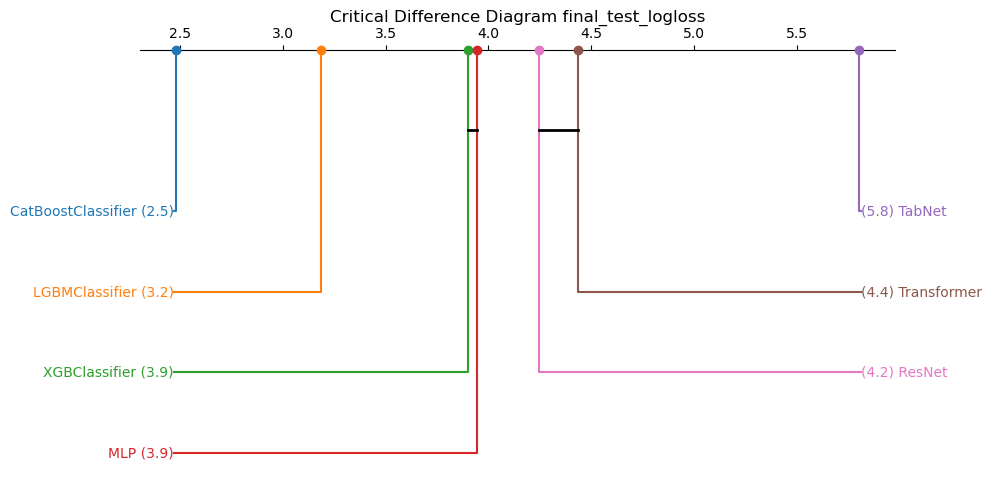

In [41]:
df = df_common.copy()
df['task_id_task_fold_seed_model'] = df['task_id'] + df['task_fold'] + df['seed_model']
metric = 'final_test_logloss'
ascending_rank = True
model_column = 'model_name'
block_column = 'task_id_task_fold_seed_model'
alpha = 0.95
res_friedman, res_nemenyi, mean_rank = friedman_nemenyi_test(df, model_column, block_column, 
                                                             metric, ascending_rank, alpha)
if res_nemenyi is not None and mean_rank is not None:
    plt.subplots(figsize=(10, 5))
    plt.title(f'Critical Difference Diagram {metric}')
    sp.critical_difference_diagram(mean_rank, res_nemenyi)
    plt.tight_layout()

/home/bbelucci/miniconda3/envs/tab_benchmark/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


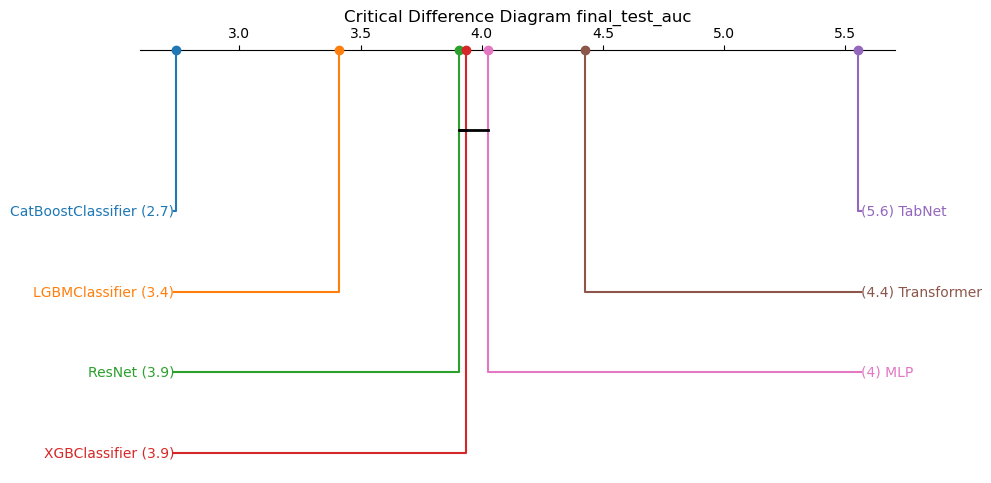

In [42]:
df = df_common.copy()
df['task_id_task_fold_seed_model'] = df['task_id'] + df['task_fold'] + df['seed_model']
metric = 'final_test_auc'
ascending_rank = False
model_column = 'model_name'
block_column = 'task_id_task_fold_seed_model'
alpha = 0.95
res_friedman, res_nemenyi, mean_rank = friedman_nemenyi_test(df, model_column, block_column, 
                                                             metric, ascending_rank, alpha)
if res_nemenyi is not None and mean_rank is not None:
    plt.subplots(figsize=(10, 5))
    plt.title(f'Critical Difference Diagram {metric}')
    sp.critical_difference_diagram(mean_rank, res_nemenyi)
    plt.tight_layout()

# Debug and explore

In [45]:
df_runs_raw[columns_names].duplicated().any()

False

In [36]:
df_to_delete = df_runs_raw.loc[df_runs_raw.test_logloss.isna()]

In [37]:
df_to_delete

key,status,start_time,end_time,dataset_name,model_name,model_nickname,seed_model,task_fold,task_id,task_name,test_auc,test_logloss,duration
run_uuid,,,,,,,,,,,,,
03cab7b441e34b40bd8ad8dc60fcd836,FINISHED,1726540996777,1726578901049,insurance_company,Transformer,TabBenchmarkTransformer,0,7,362081,binary_classification,NaN,NaN,10.528964
049febc2449c46c3afdd56d2afcaff5c,FINISHED,1726551253408,1726578901052,GesturePhaseSegmentationProcessed,Transformer,TabBenchmarkTransformer,0,4,14969,classification,NaN,NaN,7.679901
04abe372bcd84f2eadaea736307038f8,FINISHED,1726579962480,1726586658278,credit,Transformer,TabBenchmarkTransformer,0,6,361055,binary_classification,NaN,NaN,1.859944
05539e85c0604675b3f93096e8bc1feb,FINISHED,1726270121868,1726270157619,kc1,Transformer,TabBenchmarkTransformer,0,7,3917,binary_classification,NaN,NaN,0.009931
0e5ef3a920bf49869074fe5950bff043,FINISHED,1726579689874,1726586658276,artificial-characters,Transformer,TabBenchmarkTransformer,0,4,14964,classification,NaN,NaN,1.935667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
f1f2c35f12104ead8b8f7e6e320c92d4,FINISHED,1726458758738,1726458823282,magic,Transformer,TabBenchmarkTransformer,0,4,146206,binary_classification,NaN,NaN,0.017929
f26f36657d21499280e65e2581921373,FINISHED,1726573970041,1726578901053,pendigits,Transformer,TabBenchmarkTransformer,0,2,32,classification,NaN,NaN,1.369726
f2def598dec344d5a4e82e1a5510e4bc,FINISHED,1726583892918,1726586658286,Pulsar-Dataset-HTRU2,Transformer,TabBenchmarkTransformer,0,5,362099,binary_classification,NaN,NaN,0.768158


In [38]:
run_uuid_query = [f"'{run_id}'" for run_id in df_to_delete.index]
run_uuid_query = ', '.join(run_uuid_query)

In [39]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    